<a href="https://colab.research.google.com/github/saurabhmathur96/Masters-Thesis/blob/master/segnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/saurabhmathur96/Semantic-and-Instance-Segmentation.git ../../Semantic-and-Instance-Segmentation

Cloning into '../../Semantic-and-Instance-Segmentation'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 40 (delta 17), reused 11 (delta 5), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [0]:
%cd ../../

/


In [0]:
!ls

bin	 gdrive  mnt   Semantic-and-Instance-Segmentation  tools
boot	 home	 opt   srv				   usr
content  lib	 proc  swift				   var
datalab  lib32	 root  sys
dev	 lib64	 run   tensorflow-2.0.0
etc	 media	 sbin  tmp


In [0]:
import sys

sys.path.append('Semantic-and-Instance-Segmentation')

In [0]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR

from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm

from collections import Counter 
import numpy as np

import train
from smooth import smooth
from data import CamVid11
from models import SegNet, init_weights

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd 'My Drive'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/My Drive


In [0]:
train_loader = DataLoader(CamVid11('CamVid/', split='train'), 
                     batch_size=5, shuffle=True)
val_loader = DataLoader(CamVid11('CamVid/', split='val'), 
                  batch_size=1, shuffle=True)

(-0.5, 479.5, 359.5, -0.5)

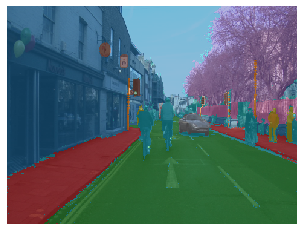

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

[x], [target] = next(iter(val))

# plt.subplot(1,2,1)
plt.imshow(x.long(), interpolation='none')
#plt.axis('off')

#plt.subplot(1,2,2)
plt.imshow(target.long(), alpha=0.5, interpolation='none', cmap='tab10')
plt.axis('off')

In [0]:
net = SegNet(3, 12)

net.apply(init_weights)

# Initialize encoder weights from VGG16 pre-trained on ImageNet
vgg16 = models.vgg16(pretrained=True)
layers = [layer for layer in vgg16.features.children() if isinstance(layer, nn.Conv2d)]

start = 0
for i in range(net.encoder.block_count):
  end = start + net.encoder.blocks[i].layer_count
  net.encoder.blocks[i].initialize_from_layers(layers[start:end])
  start = end

In [0]:
from tqdm.auto import tqdm 

frequencies = {i: [] for i in range(0, 11+1)}

for _, target in tqdm(train_loader):
  for t in target:
    count = Counter(t.flatten().numpy())
    for key, value in count.items():
      frequencies[key] += [value]
weights = []
median = np.median(sum(frequencies.values(), []))

for classid in range(0, 11+1):
  print (classid, '\t', np.sum(frequencies[classid]))
  weights.append(median/np.sum(frequencies[classid]))

0 	 10682767
1 	 14750079
2 	 623349
3 	 20076880
4 	 2845085
5 	 6166762
6 	 743859
7 	 714595
8 	 3719877
9 	 405385
10 	 184967
11 	 2503995


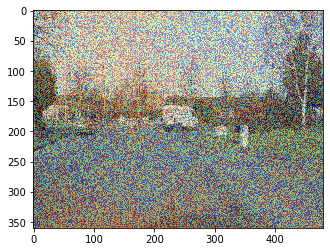

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

(x, target) = next(iter(train_loader))

#plt.subplot(1,2,1)
plt.imshow(x[0].long(), interpolation='none')
#plt.axis('off')


[p] = net(x[0][None, ].permute(0, 3, 1, 2).float().to('cuda'))
# plt.subplot(1,2,2)
plt.imshow(torch.softmax(p, dim=1).argmax(0).cpu().long(), alpha=0.5, interpolation='none', cmap='jet')
# plt.axis('off')

In [0]:
from tqdm.auto import trange, tqdm

criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights).to('cuda'))
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9999)

epochs = 25
train_losses = []
for epoch in range(epochs):
  print (f'Epoch {epoch}/{epochs}:')
  losses = train.train_epoch(train_loader, net, criterion, optimizer, scheduler)
  print ('Train Loss: %.4f' % np.mean(losses))
  train_losses += losses

Epoch 0/25:


Train Loss: 1.6860
Epoch 1/25:


Train Loss: 1.5741
Epoch 2/25:


Train Loss: 1.5030
Epoch 3/25:


Train Loss: 1.4652
Epoch 4/25:


Train Loss: 1.4551
Epoch 5/25:


Train Loss: 1.4032
Epoch 6/25:


KeyboardInterrupt: ignored

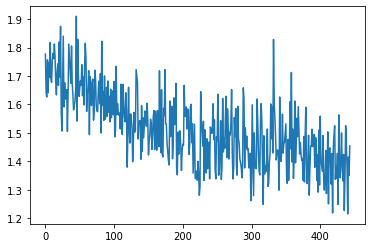

In [0]:
plt.plot(train_losses)

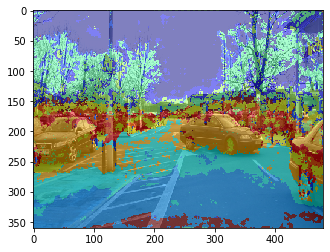

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

(x, target) = next(iter(train_loader))

#plt.subplot(1,2,1)
plt.imshow(x[0].long(), interpolation='none')
#plt.axis('off')


[p] = net(x[0][None, ].permute(0, 3, 1, 2).float().to('cuda'))
# plt.subplot(1,2,2)
plt.imshow(torch.softmax(p, dim=1).argmax(0).cpu().long(), alpha=0.5, interpolation='none', cmap='jet')
# plt.axis('off')

In [0]:
!pip install pydensecrf

     |████████████████████████████████| 1.0MB 4.9MB/s 
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc3-cp36-cp36m-linux_x86_64.whl size=2153840 sha256=bff18cad542ef0f60bfe7e3e7e442d8bb6435c394620a0144230189864193fff
  Stored in directory: /root/.cache/pip/wheels/92/6f/ec/5c49c25de8c42c872de50ff53582ba3ead850ce52a81e73ac7
Successfully built pydensecrf


Total 12 labels
360x480 image


(-0.5, 479.5, 359.5, -0.5)

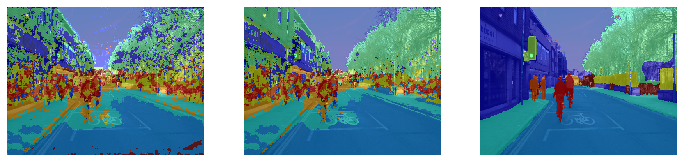

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image


plt.figure(figsize=(12, 4))
(x, target) = next(iter(val_loader))

plt.subplot(1,3,1)
plt.imshow(x[0].long(), interpolation='none')
plt.axis('off')
# plt.subplot(1,2,2)


[p] = net(x[0][None, ].permute(0, 3, 1, 2).float().to('cuda'))

mask = torch.softmax(p, dim=1).argmax(0).cpu().long().numpy().astype(np.uint8)
plt.imshow(mask, alpha=0.5, interpolation='none', cmap='jet')

mask = np.array(Image.fromarray(mask).convert('RGB')).astype(np.uint8)
image = x[0].long().cpu().numpy().astype(np.uint8)

mask = smooth(image, mask)
plt.subplot(1,3,2)
plt.imshow(x[0].long(), interpolation='none')
plt.imshow(mask, alpha=0.5, interpolation='none', cmap='jet')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(x[0].long(), interpolation='none')
plt.imshow(target[0], alpha=0.5, interpolation='none', cmap='jet')
plt.axis('off')